In [256]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import geo

In [ ]:
from functools import lru_cache
import requests

In [ ]:
data = pd.read_csv('data_bc.csv')
dataBC = data[data['addressRegion'] == 'BC']
dataBC = dataBC.sort_values(by='addressLocality')
dataBC.head()

In [ ]:
dataBC = dataBC.filter([
    'streetAddress',
    'addressLocality',
    'addressRegion',
    'postalCode',
    'latitude',
    'longitude',
    'price',
    'property-beds',
    'property-baths',
    'property-sqft',
    'Garage',
    'Property Type', #Agricultural, Condo, Condo/Townhouse, Duplex, Manufactured Home, Mobile Home, MultiFamily, Single Family, Townhome, Vacant Land
    'Square Footage',
    ])
# data_bc_single_family = dataBC[dataBC['Property Type'] == 'Single Family']
property_types = ['Single Family','Condo', 'Townhome', 'MultiFamily']
data_bc_single_family = dataBC[dataBC['Property Type'].isin(property_types)]

In [ ]:
metro_vancouver_cities = [
    "Vancouver", "Burnaby", "Richmond", "Surrey", "Coquitlam",
    "North Vancouver", "West Vancouver", "New Westminster",
    "Delta", "Port Coquitlam", "Port Moody", "Langley"
]
data_bc_single_family = data_bc_single_family[data_bc_single_family['addressLocality'].isin(metro_vancouver_cities)]
sample = data_bc_single_family.head()
sample

In [ ]:
# data_bc_single_family.sort_values(by='Price', ascending=False)
# data_bc_single_family.to_csv('data_bc_1.csv')

In [ ]:
lat_lon_array = data_bc_single_family[['latitude', 'longitude']].to_numpy()
lat_lon_array

In [222]:
def get_specific_amenities_uncached(lat, lon, radius=3000):
    # Overpass API query to find specific amenities within the radius
    overpass_url = "http://overpass-api.de/api/interpreter"
    
    # Overpass API query to find schools, transportation, convenience stores, grocery stores
    query = f"""
    [out:json];
    (
      node["amenity"="school"](around:{radius},{lat},{lon});
      node["amenity"="university"](around:{radius},{lat},{lon});
      node["amenity"="bus_station"](around:{radius},{lat},{lon});
      node["shop"="convenience"](around:{radius},{lat},{lon});
      node["shop"="grocery"](around:{radius},{lat},{lon});
    );
    out body;
    """
    
    # Send request to Overpass API
    # node["amenity"="taxi"](around:{radius},{lat},{lon});
    #   node["amenity"="subway_station"](around:{radius},{lat},{lon});
    #   node["amenity"="railway_station"](around:{radius},{lat},{lon});
    # node["amenity"="fast_food"](around:{radius},{lat},{lon});
    response = requests.get(overpass_url, params={'data': query})
    
    if response.status_code == 200:
        data = response.json()
        
        # List of amenities 
        amenities = []
        
        for element in data['elements']:
            if 'tags' in element:
                amenity = {
                    'type': element.get('type'),
                    'id': element.get('id'),
                    'name': element['tags'].get('name', 'N/A'),
                    'amenity': element['tags'].get('amenity', 'N/A'),
                    'shop': element['tags'].get('shop', 'N/A'),
                    'latitude': element['lat'] if 'lat' in element else None,
                    'longitude': element['lon'] if 'lon' in element else None
                }
                amenities.append(amenity)
        
        return amenities
    else:
        print(f"Error fetching amenities: {response.status_code}")
        return None
    
@lru_cache(maxsize=10000)
def get_specific_amenities(lat, lon, radius=3000):
    rounded_lat = round(lat, 4)
    rounded_lon = round(lon, 4)
    return get_specific_amenities_uncached(rounded_lat, rounded_lon, radius)

def haversine_vectorized(lat1, lon1, lat2, lon2):
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(np.array(lat2))
    lon2 = np.radians(np.array(lon2))
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))

    R = 6371.0

    return R * c

In [223]:
# write code here for using geo.haversine() to get individual address distances

results = []
for lat, lon in lat_lon_array:
    amenities = get_specific_amenities(lat, lon, radius=3000)
    conv_distance = []
    transit_distance = []
    school_distance = []

    if amenities:
        for a in amenities:
            dist = haversine_vectorized(lat, lon, a['latitude'], a['longitude'])
            if a.get('shop') in ['convencince', 'grocery']:
                conv_distance.append(dist)
            elif a.get('amenity') in ['bus_station', 'subway_station', 'railway_station']:
                transit_distance.append(dist)
            elif a.get('amenity') in ['school', 'university']:
                school_distance.append(dist)
            
    results.append({
        'latitude': lat,
        'longitude': lon,
        'avg_convenience_dist': np.mean(conv_distance),
        'avg_transit_distance': np.mean(transit_distance),
        'avg_school_distance': np.mean(school_distance)
    })

results_df = pd.DataFrame(results)
results_df

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


,latitude,longitude,avg_convenience_dist,avg_transit_distance,avg_school_distance
0,49.284733,-122.979824,NaN,NaN,2.351229
1,49.232249,-122.921209,NaN,2.485465,NaN
2,49.249691,-122.894086,NaN,1.020296,NaN
3,49.235055,-122.950665,2.691901,NaN,2.436122
4,49.226336,-123.006607,1.946606,NaN,1.542220
...,...,...,...,...,...
13353,49.326649,-123.134209,1.597635,0.318176,1.837962
13354,49.331529,-123.141157,1.150848,0.537051,1.728082
13355,49.344583,-123.219085,NaN,NaN,NaN
13356,49.238982,-123.139048,1.461060,NaN,1.437178


In [250]:
results_df.head()

,latitude,longitude,avg_convenience_dist,avg_transit_distance,avg_school_distance
0,49.284733,-122.979824,NaN,NaN,2.351229
1,49.232249,-122.921209,NaN,2.485465,NaN
2,49.249691,-122.894086,NaN,1.020296,NaN
3,49.235055,-122.950665,2.691901,NaN,2.436122
4,49.226336,-123.006607,1.946606,NaN,1.542220


In [252]:
results_df.to_json("amenities_distances.json", orient="records")
results_df.to_csv('amenities_distances.csv', index=False)

In [225]:
data_bc_single_family = data_bc_single_family.merge(
    results_df,
    how='left',
    on=['latitude', 'longitude']
)

In [ ]:
geo.save_cache()

In [ ]:
# WE ARE GOING TO HAVE TO SAVE THIS AS BOTH A JUPYTER NOTEBOOK (since that's the source)
# AND ALSO A .PY FILE IN CASE THE PROF WANTS TO RUN IT THAT WAY. THIS CODE IS ONLY FOR 
# THE .PY FILE OR TO SAVE TIME. OTHERWISE WE SHOULD BE ABLE TO CACHE IT

# def enrich_main_data(main_df, amenities_df):
#     return main_df.merge(
#         amenities_df,
#         on=['latitude', 'longitude'],
#         how='left'
#     )

# amenities_data = pd.read_csv('amenities_distances.csv')

# data_bc_single_family = enrich_main_data(data_bc_single_family, amenities_data)

In [226]:
data_bc_single_family

,streetAddress,addressLocality,addressRegion,postalCode,latitude,longitude,price,property-beds,property-baths,property-sqft,Garage,Property Type,Square Footage,avg_convenience_dist,avg_transit_distance,avg_school_distance
0,"51 N SEA AVENUE, Burnaby, BC V5B 1K4",Burnaby,BC,V5B 1K4,49.284733,-122.979824,2188000.0,5.0,3.0,"2,515",NaN,Single Family,"2,515 SQFT",NaN,NaN,2.351229
1,"3 7501 CUMBERLAND STREET, Burnaby, BC V3N 4Y6",Burnaby,BC,V3N 4Y6,49.232249,-122.921209,1250000.0,3.0,3.0,"1,790",NaN,Townhome,"1,790 SQFT",NaN,2.485465,NaN
2,"3 7501 CUMBERLAND STREET, Burnaby, BC V3N 4Y6",Burnaby,BC,V3N 4Y6,49.232249,-122.921209,1250000.0,3.0,3.0,"1,790",NaN,Townhome,"1,790 SQFT",NaN,2.485465,NaN
3,"1601 3833 EVERGREEN PLACE, Burnaby, BC V3J 0M2",Burnaby,BC,V3J 0M2,49.249691,-122.894086,978000.0,3.0,2.0,950,NaN,Condo,950 SQFT,NaN,1.020296,NaN
4,"1601 3833 EVERGREEN PLACE, Burnaby, BC V3J 0M2",Burnaby,BC,V3J 0M2,49.249691,-122.894086,978000.0,3.0,2.0,950,NaN,Condo,950 SQFT,NaN,1.020296,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51827,"14E 328 TAYLOR WAY, West Vancouver, BC V7T 2Y4",West Vancouver,BC,V7T 2Y4,49.326649,-123.134209,1245000.0,2.0,2.0,"1,349",NaN,Condo,"1,349 SQFT",1.597635,0.318176,1.837962
51828,"959 ANDERSON CRESCENT, West Vancouver, BC V7T 1S6",West Vancouver,BC,V7T 1S6,49.331529,-123.141157,4800000.0,4.0,4.0,"3,354",NaN,Single Family,"3,354 SQFT",1.150848,0.537051,1.728082
51829,"3722 SOUTHRIDGE PLACE, West Vancouver, BC V7V 3H8",West Vancouver,BC,V7V 3H8,49.344583,-123.219085,4270000.0,5.0,5.0,"3,650",NaN,Single Family,"3,650 SQFT",NaN,NaN,NaN
51830,"36 BEACH DRIVE, West Vancouver, BC V0N 3Z1",West Vancouver,BC,V0N 3Z1,49.238982,-123.139048,1958000.0,3.0,3.0,"2,406",NaN,Townhome,"2,406 SQFT",1.461060,NaN,1.437178


In [ ]:
print(sample['price'])

In [227]:
censusdata = pd.read_csv('CensusProfile2021.csv', encoding='latin1')
filtered_df = censusdata[censusdata.iloc[:, 0].str.contains("Income of individuals in", case=False, na=False)]
final_df = filtered_df[filtered_df.iloc[:, 1].str.contains("average|median", case=False, na=False)]
final_2020_df = final_df[
    final_df.iloc[:, 0].str.contains("2020", na=False) |
    final_df.iloc[:, 1].str.contains("2020", na=False)
]
final_2020_df = final_2020_df[final_2020_df.iloc[:, 1].str.contains("Median employment income in 2020 for full-year full-time workers in 2020", case=False, na=False)] 
# print(final_2020_df)
#final_2020_df.to_csv('CensusData_cleaned')
final_2020_df['Unnamed: 2'] = pd.to_numeric(final_2020_df['Unnamed: 2'], errors='coerce')
median_income = final_2020_df['Unnamed: 2'].iloc[0]

In [229]:

data_bc_single_family['Price-to-income Ratio'] = data_bc_single_family['price'] / median_income 
data_bc_single_family

,streetAddress,addressLocality,addressRegion,postalCode,latitude,longitude,price,property-beds,property-baths,property-sqft,Garage,Property Type,Square Footage,avg_convenience_dist,avg_transit_distance,avg_school_distance,Price-to-income Ratio
0,"51 N SEA AVENUE, Burnaby, BC V5B 1K4",Burnaby,BC,V5B 1K4,49.284733,-122.979824,2188000.0,5.0,3.0,"2,515",NaN,Single Family,"2,515 SQFT",NaN,NaN,2.351229,33.661538
1,"3 7501 CUMBERLAND STREET, Burnaby, BC V3N 4Y6",Burnaby,BC,V3N 4Y6,49.232249,-122.921209,1250000.0,3.0,3.0,"1,790",NaN,Townhome,"1,790 SQFT",NaN,2.485465,NaN,19.230769
2,"3 7501 CUMBERLAND STREET, Burnaby, BC V3N 4Y6",Burnaby,BC,V3N 4Y6,49.232249,-122.921209,1250000.0,3.0,3.0,"1,790",NaN,Townhome,"1,790 SQFT",NaN,2.485465,NaN,19.230769
3,"1601 3833 EVERGREEN PLACE, Burnaby, BC V3J 0M2",Burnaby,BC,V3J 0M2,49.249691,-122.894086,978000.0,3.0,2.0,950,NaN,Condo,950 SQFT,NaN,1.020296,NaN,15.046154
4,"1601 3833 EVERGREEN PLACE, Burnaby, BC V3J 0M2",Burnaby,BC,V3J 0M2,49.249691,-122.894086,978000.0,3.0,2.0,950,NaN,Condo,950 SQFT,NaN,1.020296,NaN,15.046154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51827,"14E 328 TAYLOR WAY, West Vancouver, BC V7T 2Y4",West Vancouver,BC,V7T 2Y4,49.326649,-123.134209,1245000.0,2.0,2.0,"1,349",NaN,Condo,"1,349 SQFT",1.597635,0.318176,1.837962,19.153846
51828,"959 ANDERSON CRESCENT, West Vancouver, BC V7T 1S6",West Vancouver,BC,V7T 1S6,49.331529,-123.141157,4800000.0,4.0,4.0,"3,354",NaN,Single Family,"3,354 SQFT",1.150848,0.537051,1.728082,73.846154
51829,"3722 SOUTHRIDGE PLACE, West Vancouver, BC V7V 3H8",West Vancouver,BC,V7V 3H8,49.344583,-123.219085,4270000.0,5.0,5.0,"3,650",NaN,Single Family,"3,650 SQFT",NaN,NaN,NaN,65.692308
51830,"36 BEACH DRIVE, West Vancouver, BC V0N 3Z1",West Vancouver,BC,V0N 3Z1,49.238982,-123.139048,1958000.0,3.0,3.0,"2,406",NaN,Townhome,"2,406 SQFT",1.461060,NaN,1.437178,30.123077


The code below is for normalizing data once we have it all cleaned up. We can ignore it for now and come back to it once we have clean data with all our columns

In [240]:
data_bc_all_values = data_bc_single_family.copy()
data_bc_all_values.head()

,streetAddress,addressLocality,addressRegion,postalCode,latitude,longitude,price,property-beds,property-baths,property-sqft,Garage,Property Type,Square Footage,avg_convenience_dist,avg_transit_distance,avg_school_distance,Price-to-income Ratio
0,"51 N SEA AVENUE, Burnaby, BC V5B 1K4",Burnaby,BC,V5B 1K4,49.284733,-122.979824,2188000.0,5.0,3.0,"2,515",NaN,Single Family,"2,515 SQFT",NaN,NaN,2.351229,33.661538
1,"3 7501 CUMBERLAND STREET, Burnaby, BC V3N 4Y6",Burnaby,BC,V3N 4Y6,49.232249,-122.921209,1250000.0,3.0,3.0,"1,790",NaN,Townhome,"1,790 SQFT",NaN,2.485465,NaN,19.230769
2,"3 7501 CUMBERLAND STREET, Burnaby, BC V3N 4Y6",Burnaby,BC,V3N 4Y6,49.232249,-122.921209,1250000.0,3.0,3.0,"1,790",NaN,Townhome,"1,790 SQFT",NaN,2.485465,NaN,19.230769
3,"1601 3833 EVERGREEN PLACE, Burnaby, BC V3J 0M2",Burnaby,BC,V3J 0M2,49.249691,-122.894086,978000.0,3.0,2.0,950,NaN,Condo,950 SQFT,NaN,1.020296,NaN,15.046154
4,"1601 3833 EVERGREEN PLACE, Burnaby, BC V3J 0M2",Burnaby,BC,V3J 0M2,49.249691,-122.894086,978000.0,3.0,2.0,950,NaN,Condo,950 SQFT,NaN,1.020296,NaN,15.046154


In [241]:
print(data_bc_all_values['Garage'].dtype)
print(data_bc_all_values['property-sqft'].dtype)

object
object


In [242]:
# features = ['Price', 'Bedrooms', 'Bathrooms', 'Acreage', 'Square Footage']
features = [
            'price',
            'property-beds', 
            'property-baths', 
            'property-sqft', 
            'Garage',
            'Property Type', 
            'avg_convenience_dist', 
            'avg_transit_distance', 
            'avg_school_distance', 
            'Price-to-income Ratio',
        ]
scaler = MinMaxScaler()
# print(sample['property-sqft'].dtype)
data_bc_all_values['property-sqft'] = (data_bc_all_values['property-sqft'].str.replace(',', '', regex=False).astype(float))
data_bc_all_values['property-sqft'] = pd.to_numeric(data_bc_all_values['property-sqft'], errors='coerce')
data_bc_all_values['Property Type'] = data_bc_all_values['Property Type'].map({'Condo': 0.25, 'Townhome': 0.5, 'Single Family': 0.75, 'MultiFamily': 1})

convenience_max = data_bc_all_values['avg_convenience_dist'].max()
transit_max = data_bc_all_values['avg_transit_distance'].max()
school_max = data_bc_all_values['avg_school_distance'].max()
data_bc_all_values['avg_convenience_dist'] = data_bc_all_values['avg_convenience_dist'].fillna(convenience_max * 1.1)
data_bc_all_values['avg_transit_distance'] = data_bc_all_values['avg_transit_distance'].fillna(transit_max * 1.1)
data_bc_all_values['avg_school_distance'] = data_bc_all_values['avg_school_distance'].fillna(school_max * 1.1)
data_bc_all_values['Garage'] = np.where(data_bc_all_values['Garage'] == 'Yes', 1, 0)


In [243]:
data_bc_all_values

,streetAddress,addressLocality,addressRegion,postalCode,latitude,longitude,price,property-beds,property-baths,property-sqft,Garage,Property Type,Square Footage,avg_convenience_dist,avg_transit_distance,avg_school_distance,Price-to-income Ratio
0,"51 N SEA AVENUE, Burnaby, BC V5B 1K4",Burnaby,BC,V5B 1K4,49.284733,-122.979824,2188000.0,5.0,3.0,2515.0,0,0.75,"2,515 SQFT",3.304471,3.303640,2.351229,33.661538
1,"3 7501 CUMBERLAND STREET, Burnaby, BC V3N 4Y6",Burnaby,BC,V3N 4Y6,49.232249,-122.921209,1250000.0,3.0,3.0,1790.0,0,0.50,"1,790 SQFT",3.304471,2.485465,3.302994,19.230769
2,"3 7501 CUMBERLAND STREET, Burnaby, BC V3N 4Y6",Burnaby,BC,V3N 4Y6,49.232249,-122.921209,1250000.0,3.0,3.0,1790.0,0,0.50,"1,790 SQFT",3.304471,2.485465,3.302994,19.230769
3,"1601 3833 EVERGREEN PLACE, Burnaby, BC V3J 0M2",Burnaby,BC,V3J 0M2,49.249691,-122.894086,978000.0,3.0,2.0,950.0,0,0.25,950 SQFT,3.304471,1.020296,3.302994,15.046154
4,"1601 3833 EVERGREEN PLACE, Burnaby, BC V3J 0M2",Burnaby,BC,V3J 0M2,49.249691,-122.894086,978000.0,3.0,2.0,950.0,0,0.25,950 SQFT,3.304471,1.020296,3.302994,15.046154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51827,"14E 328 TAYLOR WAY, West Vancouver, BC V7T 2Y4",West Vancouver,BC,V7T 2Y4,49.326649,-123.134209,1245000.0,2.0,2.0,1349.0,0,0.25,"1,349 SQFT",1.597635,0.318176,1.837962,19.153846
51828,"959 ANDERSON CRESCENT, West Vancouver, BC V7T 1S6",West Vancouver,BC,V7T 1S6,49.331529,-123.141157,4800000.0,4.0,4.0,3354.0,0,0.75,"3,354 SQFT",1.150848,0.537051,1.728082,73.846154
51829,"3722 SOUTHRIDGE PLACE, West Vancouver, BC V7V 3H8",West Vancouver,BC,V7V 3H8,49.344583,-123.219085,4270000.0,5.0,5.0,3650.0,0,0.75,"3,650 SQFT",3.304471,3.303640,3.302994,65.692308
51830,"36 BEACH DRIVE, West Vancouver, BC V0N 3Z1",West Vancouver,BC,V0N 3Z1,49.238982,-123.139048,1958000.0,3.0,3.0,2406.0,0,0.50,"2,406 SQFT",1.461060,3.303640,1.437178,30.123077


In [246]:
data_scaled = data_bc_all_values.copy()
data_scaled["price"] = 1 - data_scaled['price']
data_scaled['avg_convenience_dist'] = 1 - data_scaled['avg_convenience_dist']
data_scaled['avg_transit_distance'] = 1 - data_scaled['avg_transit_distance']
data_scaled['avg_school_distance'] = 1 - data_scaled['avg_school_distance']
# data_scaled['Parking'] = data_scaled['Parking'].map({'Yes': 1, 'No': 0})
data_scaled[features] = scaler.fit_transform(data_bc_all_values[features])
data_scaled = data_scaled.dropna()
data_scaled

,streetAddress,addressLocality,addressRegion,postalCode,latitude,longitude,price,property-beds,property-baths,property-sqft,Garage,Property Type,Square Footage,avg_convenience_dist,avg_transit_distance,avg_school_distance,Price-to-income Ratio
0,"51 N SEA AVENUE, Burnaby, BC V5B 1K4",Burnaby,BC,V5B 1K4,49.284733,-122.979824,0.037175,0.3125,0.250000,0.006413,0.0,0.666667,"2,515 SQFT",1.000000,1.000000,0.704085,0.037175
1,"3 7501 CUMBERLAND STREET, Burnaby, BC V3N 4Y6",Burnaby,BC,V3N 4Y6,49.232249,-122.921209,0.021222,0.1875,0.250000,0.004563,0.0,0.333333,"1,790 SQFT",1.000000,0.747657,1.000000,0.021222
2,"3 7501 CUMBERLAND STREET, Burnaby, BC V3N 4Y6",Burnaby,BC,V3N 4Y6,49.232249,-122.921209,0.021222,0.1875,0.250000,0.004563,0.0,0.333333,"1,790 SQFT",1.000000,0.747657,1.000000,0.021222
3,"1601 3833 EVERGREEN PLACE, Burnaby, BC V3J 0M2",Burnaby,BC,V3J 0M2,49.249691,-122.894086,0.016596,0.1875,0.166667,0.002421,0.0,0.000000,950 SQFT,1.000000,0.295766,1.000000,0.016596
4,"1601 3833 EVERGREEN PLACE, Burnaby, BC V3J 0M2",Burnaby,BC,V3J 0M2,49.249691,-122.894086,0.016596,0.1875,0.166667,0.002421,0.0,0.000000,950 SQFT,1.000000,0.295766,1.000000,0.016596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51827,"14E 328 TAYLOR WAY, West Vancouver, BC V7T 2Y4",West Vancouver,BC,V7T 2Y4,49.326649,-123.134209,0.021137,0.1250,0.166667,0.003438,0.0,0.000000,"1,349 SQFT",0.472733,0.079217,0.544505,0.021137
51828,"959 ANDERSON CRESCENT, West Vancouver, BC V7T 1S6",West Vancouver,BC,V7T 1S6,49.331529,-123.141157,0.081598,0.2500,0.333333,0.008553,0.0,0.666667,"3,354 SQFT",0.334714,0.146723,0.510342,0.081598
51829,"3722 SOUTHRIDGE PLACE, West Vancouver, BC V7V 3H8",West Vancouver,BC,V7V 3H8,49.344583,-123.219085,0.072584,0.3125,0.416667,0.009308,0.0,0.666667,"3,650 SQFT",1.000000,1.000000,1.000000,0.072584
51830,"36 BEACH DRIVE, West Vancouver, BC V0N 3Z1",West Vancouver,BC,V0N 3Z1,49.238982,-123.139048,0.033263,0.1875,0.250000,0.006135,0.0,0.333333,"2,406 SQFT",0.430543,1.000000,0.419897,0.033263


In [257]:
score_features = [
            'price',
            'property-beds', 
            'property-baths', 
            'property-sqft', 
            'Garage',
            'Property Type', 
            'avg_convenience_dist', 
            'avg_transit_distance', 
            'avg_school_distance', 
            'Price-to-income Ratio',
        ]

weights = np.array([1/len(score_features)] * len(score_features))
# print(weights)
data_scored = data_scaled.copy()
data_scored['Score'] = data_scaled[score_features].dot(weights)
data_scored.sort_values(by='Score', ascending=False, inplace=True)
data_scored

,streetAddress,addressLocality,addressRegion,postalCode,latitude,longitude,price,property-beds,property-baths,property-sqft,Garage,Property Type,Square Footage,avg_convenience_dist,avg_transit_distance,avg_school_distance,Price-to-income Ratio,Score
51140,"3330 RADCLIFFE AVENUE, West Vancouver, BC V7V 1G6",West Vancouver,BC,V7V 1G6,49.340359,-123.208444,1.000000,0.3125,0.583333,0.025362,0.0,0.666667,"9,944 SQFT",1.000000,1.000000,1.000000,1.000000,0.658786
46562,"4838 BELMONT AVENUE, Vancouver, BC V6T 1A9",Vancouver,BC,V6T 1A9,49.274890,-123.221204,0.846933,0.3125,0.666667,0.031652,0.0,0.666667,"12,410 SQFT",1.000000,1.000000,0.635906,0.846933,0.600726
45887,"4788 BELMONT AVENUE, Vancouver, BC V6T 1A9",Vancouver,BC,V6T 1A9,49.274912,-123.219831,0.491273,0.4375,1.000000,0.025702,0.0,0.666667,"10,077 SQFT",1.000000,1.000000,0.641566,0.491273,0.575398
18598,"828 BEACHVIEW DRIVE, North Vancouver, BC V7G 1R1",North Vancouver,BC,V7G 1R1,49.313394,-122.949037,0.238067,0.5625,1.000000,0.033066,0.0,0.666667,"12,964 SQFT",1.000000,1.000000,1.000000,0.238067,0.573837
22578,"14791 WESTMINSTER HIGHWAY, Richmond, BC V6V 1A4",Richmond,BC,V6V 1A4,49.170036,-123.058770,0.336710,0.5000,1.000000,0.039075,0.0,0.666667,"15,320 SQFT",1.000000,1.000000,0.849233,0.336710,0.572839
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51762,"309 1363 CLYDE AVENUE, West Vancouver, BC V7T 2W9",West Vancouver,BC,V7T 2W9,49.329062,-123.153651,0.013875,0.1250,0.083333,0.002089,0.0,0.000000,820 SQFT,0.044007,0.325558,0.449409,0.013875,0.105715
51353,"206 1363 CLYDE AVENUE, West Vancouver, BC V7T 2W9",West Vancouver,BC,V7T 2W9,49.329062,-123.153651,0.013552,0.1250,0.083333,0.002000,0.0,0.000000,785 SQFT,0.044007,0.325558,0.449409,0.013552,0.105641
51352,"206 1363 CLYDE AVENUE, West Vancouver, BC V7T 2W9",West Vancouver,BC,V7T 2W9,49.329062,-123.153651,0.013552,0.1250,0.083333,0.002000,0.0,0.000000,785 SQFT,0.044007,0.325558,0.449409,0.013552,0.105641
51312,"603 1420 DUCHESS AVENUE, West Vancouver, BC V7...",West Vancouver,BC,V7T 1H8,49.329449,-123.154866,0.011511,0.0625,0.083333,0.002523,0.0,0.000000,990 SQFT,0.033608,0.354930,0.455907,0.011511,0.101582


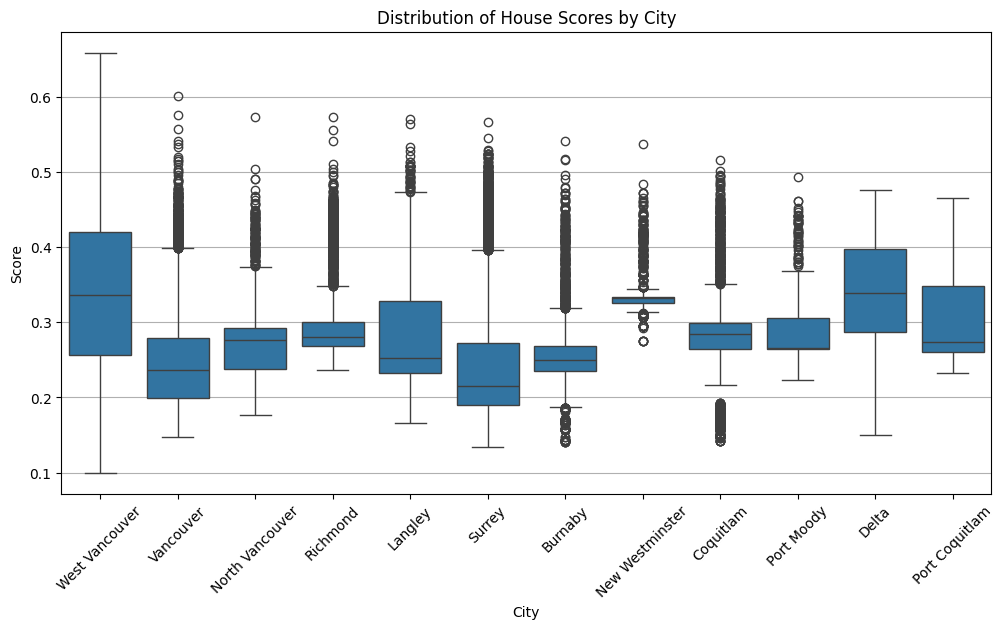

In [258]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='addressLocality', y='Score', data=data_scored)

plt.title('Distribution of House Scores by City')
plt.xlabel('City')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

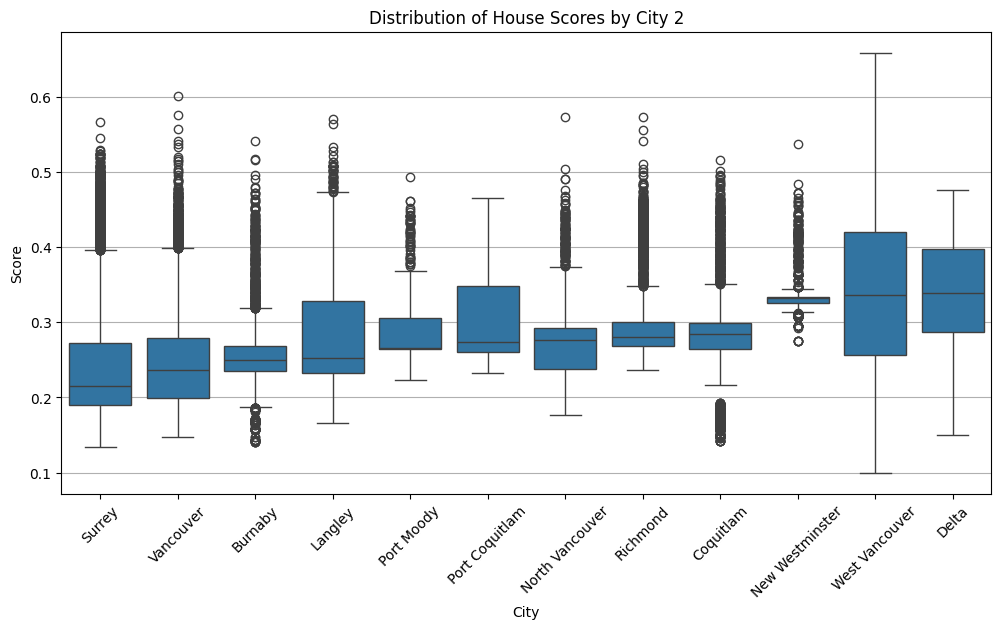

In [259]:
medians = data_scored.groupby('addressLocality')['Score'].median().sort_values()
cities = medians.index.to_list()

plt.figure(figsize=(12, 6))
sns.boxplot(x='addressLocality', y='Score', data=data_scored, order=cities)

plt.title('Distribution of House Scores by City 2')
plt.xlabel('City')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     5336.
Date:                Fri, 11 Apr 2025   Prob (F-statistic):               0.00
Time:                        23:15:34   Log-Likelihood:             1.3084e+05
No. Observations:               51652   AIC:                        -2.617e+05
Df Residuals:                   51645   BIC:                        -2.616e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0021 

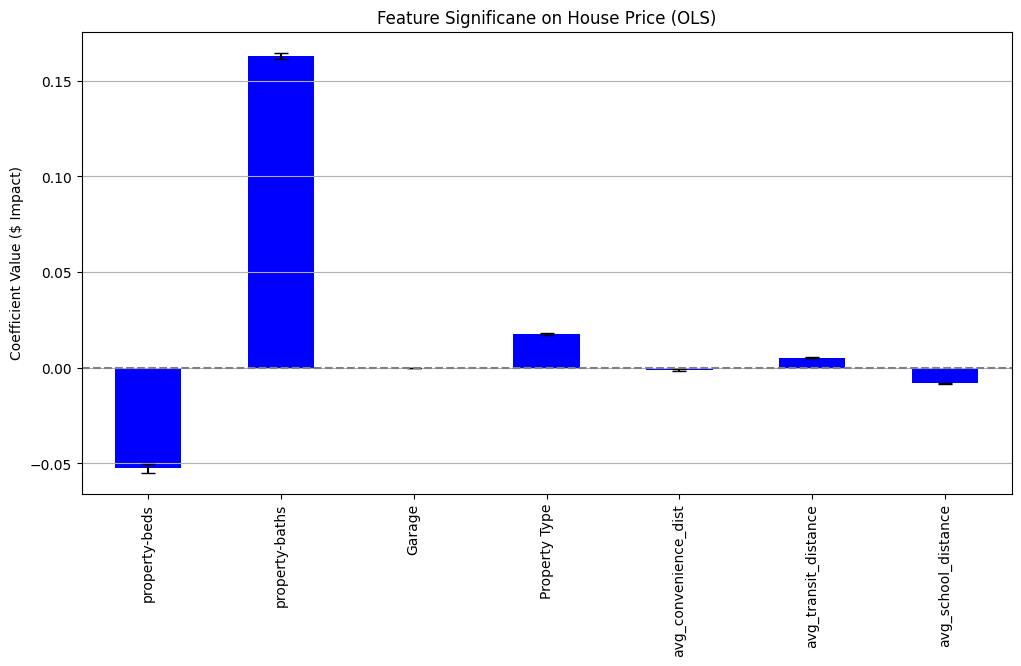

In [263]:
X = data_scored[[
                # 'price',
                'property-beds',
                'property-baths',
                'property-sqft',
                'Garage',
                'Property Type',
                'avg_convenience_dist',
                'avg_transit_distance',
                'avg_school_distance',
                # 'Price-to-income Ratio'
                ]]
X = sm.add_constant(X)
y = data_scored['price']

model = sm.OLS(y, X).fit()
coefficients = model.params.drop('const')
errors = model.bse.drop('const')
model_summary = model.summary()

print(model_summary)

plt.figure(figsize=(12, 6))
coefficients.plot(kind='bar', yerr=errors, capsize=5, color='blue')
plt.title('Feature Significane on House Price (OLS)')
plt.ylabel('Coefficient Value ($ Impact)')
plt.axhline(0, color='gray', linestyle='--')
plt.grid(True, axis='y')
plt.show()


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.383
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     5336.
Date:                Fri, 11 Apr 2025   Prob (F-statistic):               0.00
Time:                        23:16:19   Log-Likelihood:             1.3084e+05
No. Observations:               51652   AIC:                        -2.617e+05
Df Residuals:                   51645   BIC:                        -2.616e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.0021 

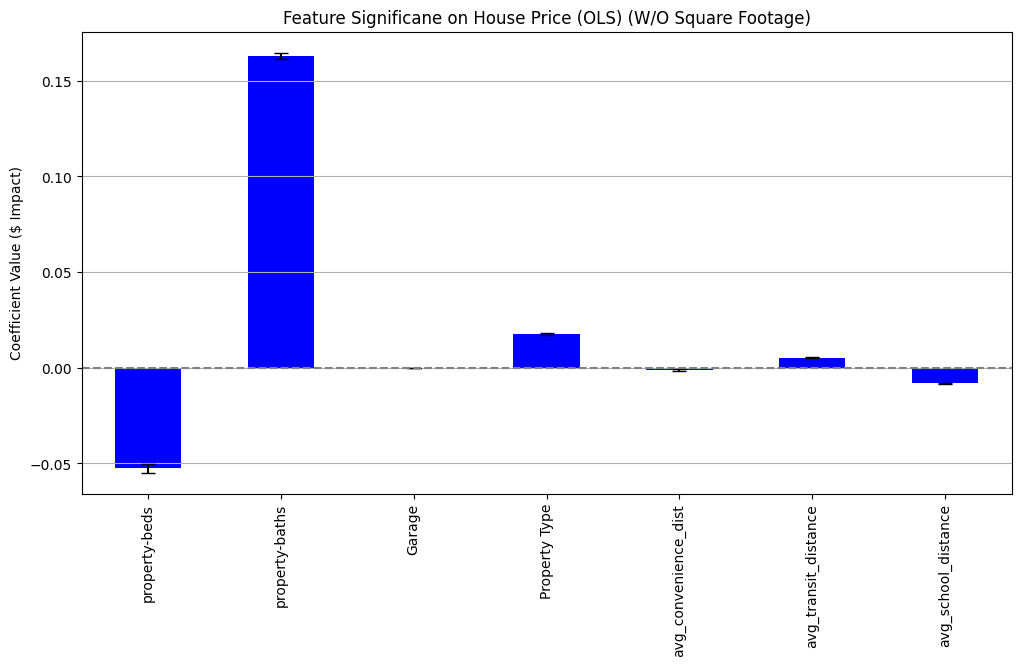

In [264]:
X = data_scored[[
                # 'price',
                'property-beds',
                'property-baths',
                # 'property-sqft',
                'Garage',
                'Property Type',
                'avg_convenience_dist',
                'avg_transit_distance',
                'avg_school_distance',
                # 'Price-to-income Ratio'
                ]]
X = sm.add_constant(X)
y = data_scored['price']

model = sm.OLS(y, X).fit()
coefficients = model.params.drop('const')
errors = model.bse.drop('const')
model_summary = model.summary()

print(model_summary)

plt.figure(figsize=(12, 6))
coefficients.plot(kind='bar', yerr=errors, capsize=5, color='blue')
plt.title('Feature Significane on House Price (OLS) (W/O Square Footage)')
plt.ylabel('Coefficient Value ($ Impact)')
plt.axhline(0, color='gray', linestyle='--')
plt.grid(True, axis='y')
plt.show()